# Preprocess Lab

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bcd.utils.image import grayscale
from bcd.utils.visual import plot_images


In [2]:
img1 = "data/image/1_dev/converted/train/benign/347c2455-cb62-40f8-a173-9e4eb9a21902.png"
img2 = "data/image/1_dev/converted/train/benign/4ed91643-1e06-4b2c-8efb-bc60dd9e0313.png"
img3 = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"
img4 = "data/image/1_dev/converted/train/malignant/596ef5db-9610-4f13-9c1a-4c411b1d957c.png"
img_filepaths = [img1, img2, img3, img4]


## Read Images

In [3]:
img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

## Original Images

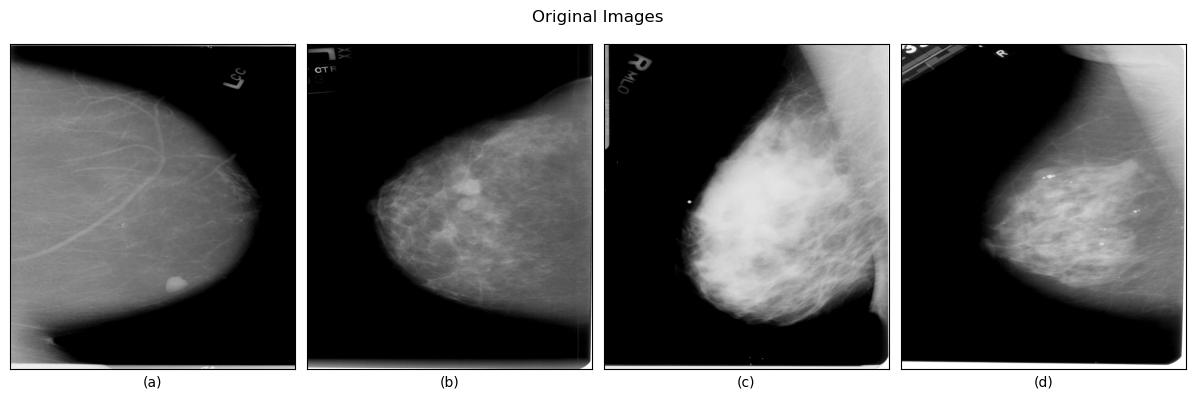

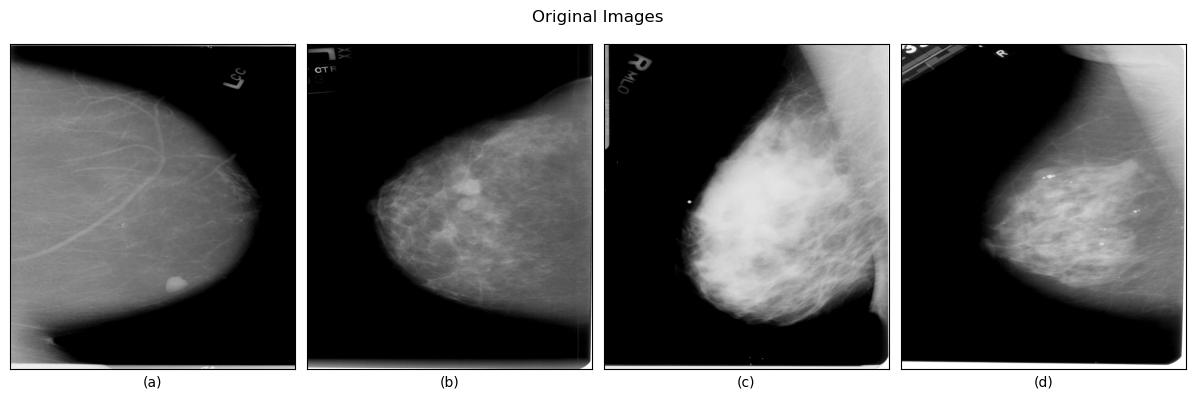

In [5]:
images = [img1,img2,img3,img4]
title = "Original Images"
plot_images(images=images, title=title)

## Denoising

In [ ]:
img1_dn = cv2.medianBlur(img1, 3)
img2_dn = cv2.medianBlur(img2, 3)
img3_dn = cv2.medianBlur(img3, 3)
img4_dn = cv2.medianBlur(img4, 3)

In [ ]:
images = [img1_dn,img2_dn,img3_dn,img4_dn]
title = "Denoised Images"
plot_images(images, title)

## Artifact Removal

### OTSU Threshold

In [ ]:
_, img1_otsu = cv2.threshold(img1_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, img2_otsu = cv2.threshold(img2_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, img3_otsu = cv2.threshold(img3_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, img4_otsu = cv2.threshold(img4_dn, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

### Find Contours

In [ ]:
img1_contours = cv2.findContours(img1_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
img2_contours = cv2.findContours(img2_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
img3_contours = cv2.findContours(img3_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
img4_contours = cv2.findContours(img4_otsu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

### Compute Contour Areas

In [ ]:
img1_contour_areas = [cv2.contourArea(cont) for cont in img1_contours]
img2_contour_areas = [cv2.contourArea(cont) for cont in img2_contours]
img3_contour_areas = [cv2.contourArea(cont) for cont in img3_contours]
img4_contour_areas = [cv2.contourArea(cont) for cont in img4_contours]

img1_idx = np.argmax(img1_contour_areas)
img2_idx = np.argmax(img2_contour_areas)
img3_idx = np.argmax(img3_contour_areas)
img4_idx = np.argmax(img4_contour_areas)

### Draw Contours

In [ ]:
img1_mask = cv2.drawContours(np.zeros_like(img1_otsu), img1_contours, img1_idx, 255, -1)
img2_mask = cv2.drawContours(np.zeros_like(img2_otsu), img2_contours, img2_idx, 255, -1)
img3_mask = cv2.drawContours(np.zeros_like(img3_otsu), img3_contours, img3_idx, 255, -1)
img4_mask = cv2.drawContours(np.zeros_like(img4_otsu), img4_contours, img4_idx, 255, -1)

### Segment the Breast

In [ ]:
img1_seg = cv2.bitwise_and(img1, img1, mask=img1_mask)
img2_seg = cv2.bitwise_and(img2, img2, mask=img2_mask)
img3_seg = cv2.bitwise_and(img3, img3, mask=img3_mask)
img4_seg = cv2.bitwise_and(img4, img4, mask=img4_mask)

### Crop the Breast

In [ ]:
def crop(img, contours):
    contour = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(contour)
    return img[y:y+h, x:x+w]
    

In [ ]:
img1_crop = crop(img1_seg, img1_contours)
img2_crop = crop(img2_seg, img2_contours)
img3_crop = crop(img3_seg, img3_contours)
img4_crop = crop(img4_seg, img4_contours)


## Enhance Image

In [ ]:
def clip_norm(img):
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    clipped = np.clip(img,Pmin, Pmax)  
    normalized = (clipped - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized    

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img1_enhanced = clahe.apply(img1_crop)
img2_enhanced = clahe.apply(img2_crop)
img3_enhanced = clahe.apply(img3_crop)
img4_enhanced = clahe.apply(img4_crop)